# Charging Stations at EPFL (GreenMotion dataset)

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
import datetime

In [2]:
DATA_FOLDER = 'data'

### A. Loading consumption phase
Load the EPFL charging stations excel file into a `DataFrames`. 

In [4]:
cs_dataframe = pd.read_excel("{}/EPFL-data-extract.xlsx".format(DATA_FOLDER), index_col=0) 

In [5]:
len(cs_dataframe[cs_dataframe['HashedUserId'] == 'empty'])

8346

### A.1 Exploring the data

Useful functions:

In [6]:
def nb_minutes(EndDate, BeginDate):
    delta = EndDate - BeginDate
    nb_min_final_day = delta.seconds//60
    nb_days = delta.days
    nb_min = nb_min_final_day + nb_days*24*60 + 1
    return nb_min

Computing charging duration and power:

In [7]:
delta_vect = cs_dataframe.apply(lambda x : nb_minutes(x.EndDate, x.BeginDate), axis=1) #compute minutes of charge
cs_dataframe["ChargingDuration"] = delta_vect 
cs_dataframe["Power"] = cs_dataframe["PowerConsumption"] / cs_dataframe["ChargingDuration"] * 60 # compute power
#cs_df = cs_dataframe.drop('HashedUserId', axis=1)
cs_df = cs_dataframe
cs_df.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power
ChargeLogId,,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,0x725B61EAA9973F5EF7FE6BE2033C5F264982C8C04ED3...,1,0.0
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0


#### give each user_id one number for easily operation

In [8]:
Userlst = list(cs_df['HashedUserId'].unique()) 
Userlst.remove('empty')                # get all user_id except for NULL
User_num = range(1, len(Userlst)+1)

In [9]:
User_collect = dict(zip(Userlst, User_num))
User_collect['empty'] = 0           # give each user_id one numer which is easierly read than Hash value

In [10]:
cs_df['HashedUserId'] = cs_df['HashedUserId'].apply(lambda x: User_collect[x])

Let's remove unrealistic charging powers:

In [12]:
cs_df_clean = cs_df[cs_df.Power < 30000] # removing outliers (P>30kW...)

In [471]:
cs_df_clean.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power,weekday
ChargeLogId,,,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,1,1,0.0,5
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,2,1,0.0,5
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,2,1,0.0,5
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,2,1,0.0,5
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,2,1,0.0,5


### A.2 clustering each data into a hour-form

In [302]:
# year 2019 data
df = cs_df_clean[cs_df_clean.BeginDate.dt.year.isin([2020,2019,2018])]
df = df.reset_index()
df = df.drop(['ChargeLogId'],axis =1)

In [304]:
df['Begintime'] = df['BeginDate'].dt.hour

In [305]:
df['Endtime'] =df['EndDate'].dt.hour

In [306]:
df['Duration_hour'] = df.apply(lambda x: x['Endtime']- x['Begintime'] + 1\
                                     if x['Endtime'] >= x['Begintime'] 
                                     else x['Endtime'] + 24 - x['Begintime'] + 1, axis =1)
#got the charging in exact hour

In [307]:
#function for dividing each charging into every hour form
df_new = pd.DataFrame()
def hour_power(x):
    a = x
    global df_new
    if a.BeginDate.hour + a.Duration_hour <= 24:
        for i in range(a.Duration_hour):
            df_new = df_new.append([pd.DataFrame(a).T])
            a.Begintime += 1
    else:
        delt_t = 24 - a.BeginDate.hour
        for i in range(delt_t):
            df_new = df_new.append([pd.DataFrame(a).T])
            a.Begintime += 1
            
        for i in range(a.Duration_hour - delt_t):
            a.BeginDate += datetime.timedelta(hours = delt_t)
            a.EndDate += datetime.timedelta(hours = delt_t)
            a.Begintime = i
            df_new = df_new.append([pd.DataFrame(a).T])
    

In [308]:
lst = pd.Series(range(0, len(df)))
lst.apply(lambda x: hour_power(df.loc[x]))

0        None
1        None
2        None
3        None
4        None
         ... 
10176    None
10177    None
10178    None
10179    None
10180    None
Length: 10181, dtype: object

In [309]:
df_new = df_new.reset_index()

In [310]:
df_new = df_new.drop(['index'], axis =1)

In [311]:
df_new['Day'] = df_new['BeginDate'].dt.date

In [312]:
power = pd.DataFrame(df_new.groupby(['Day','Begintime'])['Power'].sum()) 
#get every day every hour's power for whole stations

In [313]:
power = power.reset_index()

In [409]:
power.columns = ['Day','Hour','Power','weekday']

In [441]:
power[power.Day == date(2020,3,12)]

,Day,Hour,Power,weekday
10905,2020-03-12,5,13498.895499,4
10906,2020-03-12,6,22519.396315,4
10907,2020-03-12,7,28984.996307,4
10908,2020-03-12,8,31225.623303,4
10909,2020-03-12,9,24483.782773,4
10910,2020-03-12,10,31327.695817,4
10911,2020-03-12,11,16862.471298,4
10912,2020-03-12,12,26825.240528,4
10913,2020-03-12,13,23540.231685,4
10914,2020-03-12,14,3783.682413,4


power_whole = pd.DataFrame()
def zero_hour(x):
    global power_whole
    for i in range(0,24):
        if i.isin(x.Hour):
            power_whole = power_whole.append(x.loc[i])

In [319]:
power['weekday'] = power['Day'].apply(lambda x: x.weekday() + 1)

### A.3 Add weather data

In [614]:
cs_weather = pd.read_csv('{}/weather.csv'.format(DATA_FOLDER), index_col = None)
cs_weather = cs_weather[cs_weather['Year'].isin([2020,2019,2018])]

In [615]:
Cha = ['Year','Month','Day','Hour','TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']
cs_weather = cs_weather[Cha]

In [616]:
cs_weather['RAIN'] = cs_weather['RAIN']\
.apply(lambda x: float(x.split('/')[0]) if x != '--' else float(0))

In [617]:
weather = cs_weather.reset_index(drop=True)

In [618]:
weather['Hour'] = weather['Hour'].apply(lambda x: int(x.split(':')[0]))

##### fill up the '--' with average value

In [619]:
weather['TMP'] = weather.apply(lambda x: float(x.TMP) if x.TMP != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.TMP != '--')]['TMP'].apply(float).mean(), axis=1)

In [620]:
weather['WNDCHILL'] = weather.apply(lambda x: float(x.WNDCHILL) if x.WNDCHILL != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.WNDCHILL != '--')]['WNDCHILL'].apply(float).mean(), axis=1)

In [621]:
weather['WNDSPD'] = weather.apply(lambda x: float(x.WNDSPD) if x.WNDSPD != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.WNDSPD != '--')]['WNDSPD'].apply(float).mean(), axis=1)

In [622]:
weather['Humidity'] = weather.apply(lambda x: float(x.Humidity) if x.Humidity != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.Humidity != '--')]['Humidity'].apply(float).mean(), axis=1)

In [605]:
weather['PRMSL'] = weather.apply(lambda x: float(x.PRMSL) if x.PRMSL != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.PRMSL != '--')]['PRMSL'].apply(float).mean(), axis=1)

In [623]:
weather.head()

,Year,Month,Day,Hour,TMP,WNDCHILL,WNDSPD,Humidity,PRMSL,RAIN
0,2018,1,1,0,7.8,6.6,7.4,82.0,1014,0.4
1,2018,1,1,1,7.0,4.0,16.7,82.0,1015.9,2.0
2,2018,1,1,2,6.1,4.6,7.4,84.0,1017.1,0.2
3,2018,1,1,3,6.1,4.6,7.4,81.0,1017.5,0.2
4,2018,1,1,4,6.5,5.6,5.6,77.0,1018.1,0.0


In [624]:
weather['Day'] = weather.apply(lambda x: date(x.Year,x.Month,x.Day), axis = 1)

In [625]:
weather = weather.drop(['Year','Month'], axis = 1)

In [626]:
weather = weather[['Day','Hour','TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']]

In [627]:
weather = weather.drop_duplicates(subset=None, keep='first', inplace=False)

###  A.4 join power and weather set together and got season, weekday/weekenday info.

In [629]:
power.head()

,Day,Hour,Power,weekday
0,2018-01-02,13,14408.601553,2
1,2018-01-02,14,14408.601553,2
2,2018-01-02,15,970.635452,2
3,2018-01-02,16,970.635452,2
4,2018-01-02,17,970.635452,2


In [630]:
df_GM = pd.merge(power, weather, how ='right', on=['Day','Hour'])

In [631]:
power_uncom = df_GM.Power.fillna(0) #fill up Nan with 0 under 'Power' column
df_GM.Power = power_uncom

In [632]:
df_GM = df_GM.groupby('Day').apply(lambda x: x.sort_values(by = 'Hour', ascending = True))

In [633]:
df_GM = df_GM.reset_index(drop = True)

#### complete season info.

In [634]:
season = {1:'Winter', 2:'Spring', 3:'Spring', 4:'Spring', 5:'Summer', 6:'Summer', 7:'Summer',\
         8:'Fall', 9:'Fall', 10:'Fall', 11:'Winter', 12:'Winter'}

In [635]:
df_GM['Season'] = df_GM.apply(lambda x: season[x.Day.month], axis=1)

In [636]:
df_GM['weekday'] = df_GM['Day'].apply(lambda x: x.weekday() + 1)

In [637]:
df_GM.head()

,Day,Hour,Power,weekday,TMP,WNDCHILL,WNDSPD,Humidity,PRMSL,RAIN,Season
0,2018-01-01,0,0.0,1,7.8,6.6,7.4,82.0,1014,0.4,Winter
1,2018-01-01,1,0.0,1,7.0,4.0,16.7,82.0,1015.9,2.0,Winter
2,2018-01-01,2,0.0,1,6.1,4.6,7.4,84.0,1017.1,0.2,Winter
3,2018-01-01,3,0.0,1,6.1,4.6,7.4,81.0,1017.5,0.2,Winter
4,2018-01-01,4,0.0,1,6.5,5.6,5.6,77.0,1018.1,0.0,Winter


In [646]:
df_GM.to_csv('data/base_data.csv',index = False)

### Now there are two main dataframe which we can use. 
#### 1. One is cs_df_clean, which represents charging data for every time
#### 2. One is df_GM, which represents charging data for every hour from 2018 to 2020.3.12 of whole stations

### B dig out some useful info.
#### 1) At what time were built each stations? 

In [25]:
min_date = cs_df_clean.groupby('ChargingStationId').min().BeginDate
min_date

ChargingStationId
118    2013-11-22 09:02:37
577    2015-06-18 13:47:10
3391   2018-10-24 13:03:13
3392   2018-10-24 12:54:51
3398   2018-10-24 12:50:27
3399   2018-10-24 12:44:34
3413   2019-06-19 08:14:33
3461   2019-05-24 13:10:39
4743   2019-01-22 14:23:54
4744   2019-01-22 14:16:46
4745   2019-01-23 08:05:05
Name: BeginDate, dtype: datetime64[ns]

#### 2) What is the charging power of each station? 

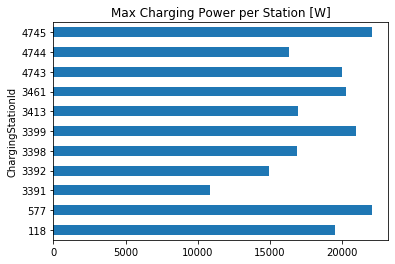

In [26]:
#compute mximum charging power
max_pow = cs_df_clean.groupby('ChargingStationId').max().Power.astype(int)
max_pow.plot(kind='barh', title='Max Charging Power per Station [W]')

Apart from station 3391, all other stations seem to be able to charge above 11kW and below 22kW. 

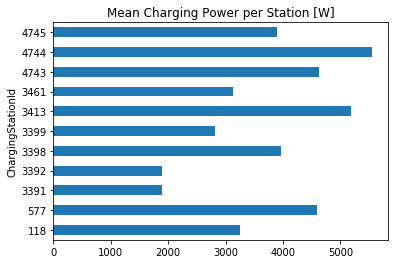

In [27]:
#compute average charging power
avg_pow = cs_df_clean.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow.plot(kind='barh', title='Mean Charging Power per Station [W]')

Most efficient charging stations seem to be **4744** and **3413** (P>5kW).   
Less efficient ones seem to be **3392** and **3391** (P<2kW).

In [48]:
datetime.now().day

14

#### 3) behavior pattern for User_Id and Null

In [28]:
from datetime import datetime

In [102]:
cs_03_02_08 = cs_df_clean[cs_df_clean.BeginDate.dt.week == 12] # data from 2020-03-02 to 2020-03-08

In [103]:
df_03_new = cs_03_02_08
df_03_new.BeginDate = cs_03_02_08.BeginDate.dt.hour
df_03_new.EndDate = cs_03_02_08.EndDate.dt.hour +1

distrib = np.zeros(24)
for i in df_03_new[df_03_new['HashedUserId'] != 0].index:
    for h in range(df_03_new.loc[i].BeginDate.astype(int), df_03_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_03_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

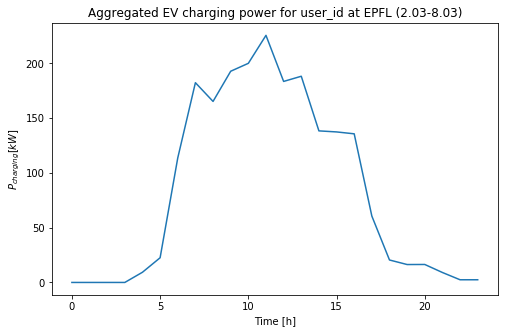

In [104]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power for user_id at EPFL (2.03-8.03)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

In [105]:

distrib = np.zeros(24)
for i in df_03_new[df_03_new['HashedUserId'] == 0].index:
    for h in range(df_03_new.loc[i].BeginDate.astype(int), df_03_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_03_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

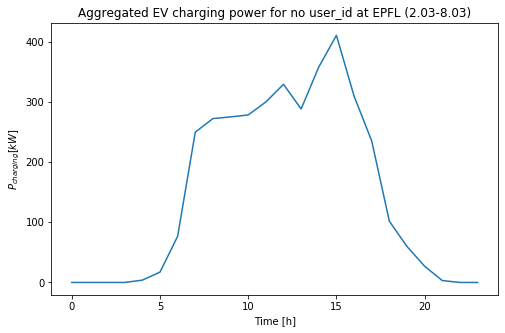

In [106]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power for no user_id at EPFL (2.03-8.03)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

It seems that the users who don't have a userid will consume more power in afternoon.

### C) Charging power profile on 09/03/2020

In [17]:
#focusing data on 09/03/2020
df_20_03_09_begin = cs_df_clean[cs_df_clean.BeginDate.dt.date == date(2020, 3, 9)]
df_20_03_09 = df_20_03_09_begin[df_20_03_09_begin.EndDate.dt.date == date(2020, 3, 9)]
df_20_03_09.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power,weekday
ChargeLogId,,,,,,,,,
711743,3392,4402,2020-03-09 12:49:43,2020-03-09 16:18:38,7650,178,209,2196.172249,1
711097,3413,4440,2020-03-09 05:13:41,2020-03-09 06:58:28,16805,253,105,9602.857143,1
711135,4745,5836,2020-03-09 05:33:25,2020-03-09 07:39:02,6578,255,126,3132.380952,1
711156,4743,5834,2020-03-09 07:58:24,2020-03-09 08:05:59,856,326,8,6420.000000,1
711399,3399,4409,2020-03-09 07:27:21,2020-03-09 11:56:52,8118,180,270,1804.000000,1


#### 1) Charging Power per Station

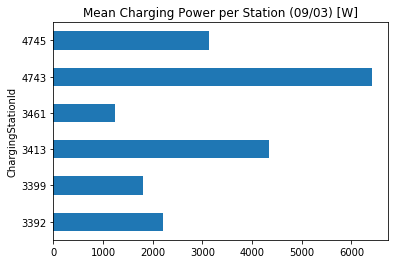

In [18]:
avg_pow_2020 = df_20_03_09.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow_2020.plot(kind='barh', title='Mean Charging Power per Station (09/03) [W]')

#### 2) Creating hourly distribution

In [19]:
df_2020_new = df_20_03_09
df_2020_new.BeginDate = df_20_03_09.BeginDate.dt.hour
df_2020_new.EndDate = df_20_03_09.EndDate.dt.hour +1

distrib = np.zeros(24)
for i in df_2020_new.index:
    for h in range(df_2020_new.loc[i].BeginDate.astype(int), df_2020_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_2020_new.loc[i].Power

Text(0.5, 0, 'Time [h]')

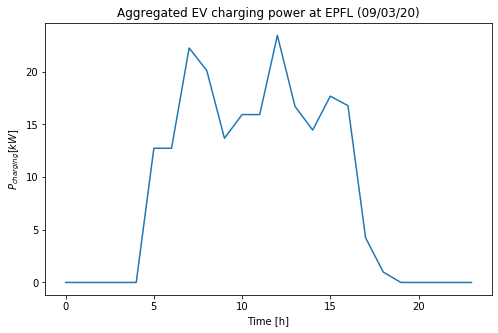

In [20]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power at EPFL (09/03/20)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')


In [21]:
distrib

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        , 12735.23809524, 12735.23809524, 22252.27240785,
       20106.23321113, 13686.23321113, 15933.2029081 , 15933.2029081 ,
       23452.15837368, 16710.52572062, 14463.55602365, 17680.87309682,
       16775.59007796,  4235.3175392 ,   986.34175566,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [648]:
aa = df_GM[df_GM.Day == date(2020, 3, 9)].Power
aa.index = df_GM[df_GM.Day == date(2020, 3, 9)].Hour

Text(0.5, 0, 'Time [h]')

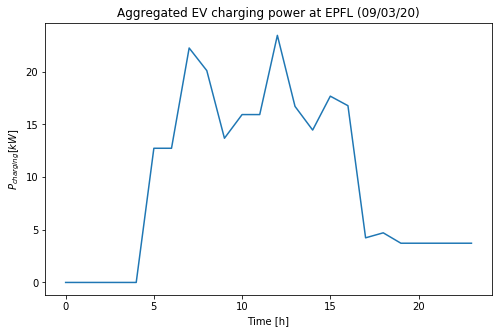

In [649]:
plt.figure(figsize=(8,5))
plt.plot(aa/1000)
plt.title('Aggregated EV charging power at EPFL (09/03/20)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')



### the images for two data set are similar. cs_df_clean does not consider the charging which spanned the midnight, by the contrary df_GM does.